### **Setup**

In [1]:
%%bash
pip install statsmodels==0.13.2 -q

### **Imports**

In [2]:
import os
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

r.seed(42)

In [3]:
def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


BASE_PATH = "../input/sidfc-make-data-per-item-per-store"
TRAIN_PATH = os.path.join(BASE_PATH, "train_files")
TEST_PATH  = os.path.join(BASE_PATH, "test_files")

In [4]:
store_id = r.randint(1, 9)
item_id = r.randint(1, 49)

tr_filename = f"tr_df_{store_id}_{item_id}.csv"
ts_filename = f"ts_df_{store_id}_{item_id}.csv"

assert tr_filename in os.listdir(TRAIN_PATH), f"Error ===> Store ID: {store_id}, Item ID: {item_id}"
assert ts_filename in os.listdir(TEST_PATH), f"Error ===> Store ID: {store_id}, Item ID: {item_id}"

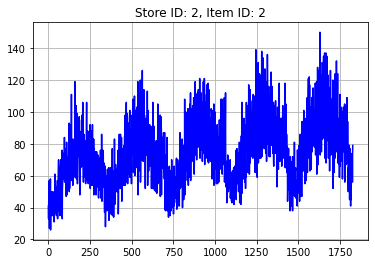

In [5]:
tr_df = pd.read_csv(os.path.join(TRAIN_PATH, tr_filename))
ts_df = pd.read_csv(os.path.join(TEST_PATH, ts_filename))

x_Axis = [i+1 for i in range(tr_df.shape[0])]
plt.figure()
plt.plot(x_Axis, tr_df["sales"], "b")
plt.grid()
plt.title(f"Store ID: {store_id}, Item ID: {item_id}")
plt.show()

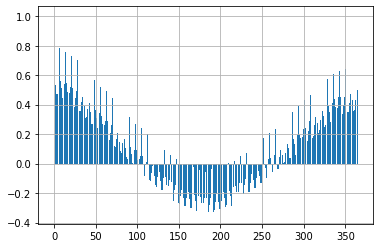

In [6]:
time_shifts = [i for i in range(366)]
corrs = []

for time_shift in range(len(time_shifts)):
    X = tr_df.sales.values
    Y = tr_df.sales.shift(time_shift).values
    Y = np.nan_to_num(Y, nan=X.mean())
    corrs.append(np.corrcoef(X, Y)[0, 1])

plt.bar(time_shifts, height=corrs)
plt.grid()
plt.show()

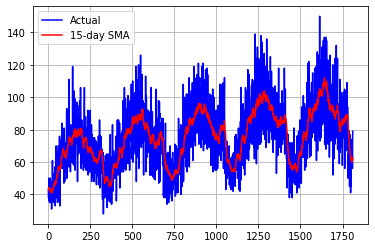

In [7]:
window_size = 15

tr_df_MA = tr_df.copy()
tr_df_MA[f"SMA{window_size}_sales"] = tr_df.sales.rolling(window_size).mean()[window_size:]
tr_df_MA = tr_df_MA.dropna()

x_Axis = [i+1 for i in range(tr_df_MA.shape[0])]

plt.figure()
plt.plot(x_Axis, tr_df_MA.sales, "b", label="Actual")
plt.plot(x_Axis, tr_df_MA[f"SMA{window_size}_sales"], "r", label=f"{window_size}-day SMA")
plt.grid()
plt.legend()
plt.show()

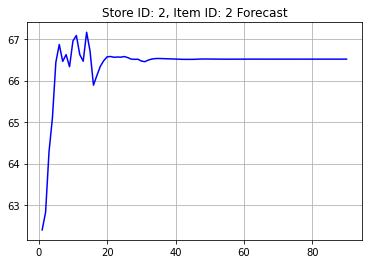

In [8]:
num_steps_into_future = 90

history = list(tr_df_MA.sales[-window_size:].copy().values)

for i in range(num_steps_into_future):
    y_pred = sum(history[i:window_size+i]) / window_size
    history.append(y_pred)

x_Axis = [i+1 for i in range(num_steps_into_future)]
plt.figure()
plt.plot(x_Axis, history[window_size:], "b")
plt.grid()
plt.title(f"Store ID: {store_id}, Item ID: {item_id} Forecast")
plt.show()

### **Statsmodels**

In [9]:
# %%bash
# pip show statsmodels

In [10]:
import statsmodels.tsa.api as tsa
from sklearn.metrics import mean_squared_error


**************************************************

MSE : 592.07887

**************************************************



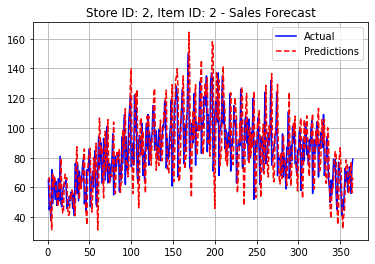


**************************************************



In [11]:
def evaluate_arima_model(tr_data: list, va_data: list, order: tuple) -> tuple:
    output: list = []

    for i in range(len(va_data)):
        model = tsa.arima.ARIMA(tr_data, order=order).fit()
        tr_data.append(va_data[i])
        output.append(model.forecast()[0])
    
    return output, mean_squared_error(va_data, output)


X = list(tr_df.sales.copy().values)
split_index = len(X)-365

tr_data = X[:split_index]
va_data = X[split_index:]
order = (2, 2, 0)

output, mse = evaluate_arima_model(tr_data, va_data, order)

breaker()
print(f"MSE : {mse:.5f}")

breaker()
x_Axis = [i+1 for i in range(len(va_data))]
plt.figure()
plt.plot(x_Axis, va_data, "b", label="Actual")
plt.plot(x_Axis, output, "r--", label="Predictions")
plt.grid()
plt.legend()
plt.title(f"Store ID: {store_id}, Item ID: {item_id} - Sales Forecast")
plt.show()

breaker()

### **Search Best**

In [12]:
orders = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)]

best_mse = np.inf

breaker()
for order in orders:
    _, mse = evaluate_arima_model(tr_data, va_data, order)
    print(f"{order} ---> {mse:.5f}")
    if mse < best_mse:
        best_mse = mse
        best_order = order

        
breaker()
print(f"Best Model : ARIMA({best_order})")

breaker()


**************************************************

(0, 0, 1) ---> 404.06723
(0, 1, 0) ---> 435.07397
(1, 0, 0) ---> 338.74250
(1, 1, 0) ---> 358.83678
(1, 0, 1) ---> 258.79374
(0, 1, 1) ---> 259.34086
(1, 1, 1) ---> 258.04831

**************************************************

Best Model : ARIMA((1, 1, 1))

**************************************************

